# K-Nearest Neighbors

**Author:** Magdalena Whelley  
**Topic:** Supervised Learning — Non-Parametric Classification with K-Nearest Neighbors

---

## 1. Overview

The **K-Nearest Neighbors (KNN)** algorithm is a simple, non-parametric method for classification.  
Unlike linear models such as the perceptron, KNN makes no assumptions about the underlying data distribution or decision boundary.  
Instead, it classifies new samples based on the **majority label** among their *k* nearest points in feature space.

In this notebook, we apply KNN to the same ETF dataset used for the perceptron — distinguishing between the **Technology (XLK)** and **Energy (XLE)** sectors based on short-term returns and volatility.

This notebook will:

- Load and preprocess ETF sector data  
- Compute return, moving-average, and volatility features  
- Train and evaluate a KNN classifier  
- Visualize classification regions and performance metrics

In [1]:
# 2. Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [7]:
# 3. Load Sector ETF Data
csv_path = "sector_knn.csv"
tickers = ["XLK", "XLE"]

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
else:
    data = yf.download(tickers, start="2020-01-01", end="2024-12-31")
    df.to_csv(csv_path)

print("Columns after flattening:", list(df.columns))
display(df.head())


Columns after flattening: ['XLE', 'XLK']


,XLE,XLK
Date,,
2020-01-02,47.418171,88.833046
2020-01-03,47.277279,87.834282
2020-01-06,47.645157,88.043564
2020-01-07,47.519924,88.005501
2020-01-08,46.737186,88.947205


## Data Description

This notebook uses **historical exchange-traded fund (ETF) price data** for two U.S. market
sectors: **Technology (XLK)** and **Energy (XLE)**. The data is obtained from **Yahoo Finance**
and consists of daily adjusted closing prices over a fixed time window.

Each ETF represents a diversified basket of stocks within its respective sector. From the
raw price data, we construct a labeled dataset by computing **short-term financial features**
for each trading day. These features include daily returns, moving-average–based indicators,
and measures of volatility, which capture short-horizon market behavior.

The resulting dataset is a **binary classification dataset**, where each sample corresponds
to a single trading day and is labeled according to the ETF’s sector (Technology or Energy).
All features are continuous and derived directly from historical price series.

Because the data is time-indexed, observations are **temporally ordered** rather than
independent and identically distributed. Care is taken to avoid look-ahead bias by computing
features using only past information. Feature scaling is applied prior to training, as
distance-based methods such as K-Nearest Neighbors are sensitive to differences in feature
magnitude.

## 4. Feature Engineering

We compute three key indicators for each ETF:

- **Daily Return:** fractional daily price change  
- **5-Day Moving Average:** short-term trend  
- **5-Day Volatility:** standard deviation of recent returns  

We then define the binary target variable:

- `1` → Technology (XLK) outperforms Energy (XLE)  
- `0` → Energy (XLE) outperforms Technology (XLK)

In [8]:
returns = df.pct_change()
rolling_mean = returns.rolling(5).mean()
rolling_vol = returns.rolling(5).std()

feat = pd.DataFrame({
    "Return_XLK": returns["XLK"],
    "Return_XLE": returns["XLE"],
    "MA_XLK": rolling_mean["XLK"],
    "MA_XLE": rolling_mean["XLE"],
    "Vol_XLK": rolling_vol["XLK"],
    "Vol_XLE": rolling_vol["XLE"]
})

feat["Target"] = np.where(feat["Return_XLK"] > feat["Return_XLE"], 1, 0)
feat.dropna(inplace=True)

print("Feature sample:")
display(feat.head())

Feature sample:


,Return_XLK,Return_XLE,MA_XLK,MA_XLE,Vol_XLK,Vol_XLE,Target
Date,,,,,,,
2020-01-09,0.011336,0.007369,0.002549,-0.001384,0.009257,0.009904,1
2020-01-10,-0.002327,-0.005653,0.004332,-0.001921,0.006333,0.010082,1
2020-01-13,0.012507,0.000334,0.006357,-0.003410,0.007123,0.008753,1
2020-01-14,-0.004711,0.000167,0.005501,-0.002851,0.008302,0.008903,0
2020-01-15,0.001157,-0.007353,0.003592,-0.001027,0.007895,0.005814,1


## 5. Data Preparation

We extract features and targets, split the dataset into training and test sets (75% / 25%),  
and standardize the features using `StandardScaler`.


In [10]:
X = feat[["Return_XLK", "Return_XLE", "MA_XLK", "MA_XLE", "Vol_XLK", "Vol_XLE"]].values
y = feat["Target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Feature matrix:", X_train.shape)
print("Target distribution:", pd.Series(y_train).value_counts().to_dict())

Feature matrix: (939, 6)
Target distribution: {1: 475, 0: 464}


## 6. Model Training — KNN Classifier

We initialize and train a KNN classifier using *k = 5* nearest neighbors and the Euclidean distance metric.


In [11]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [12]:
# 7. Evaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")

print("Confusion Matrix:")
print(cm)

Test Accuracy: 91.69%
Precision: 0.906
Recall: 0.948
Confusion Matrix:
[[124  17]
 [  9 163]]


## 8. Visualizing the Decision Boundary (2D Projection)

We project the data onto the two most intuitive dimensions — **Return_XLK** and **Return_XLE** —  
and visualize the KNN decision regions.


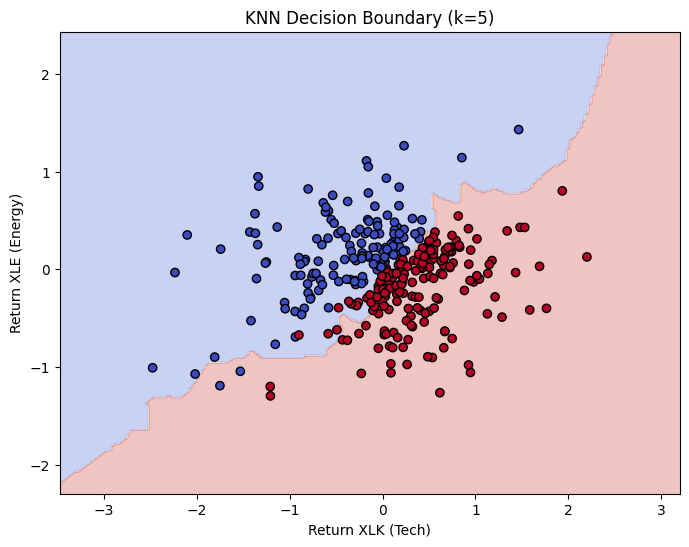

In [13]:
def plot_knn_boundary(X, y, model):
    X_vis = X[:, :2]
    x_min, x_max = X_vis[:,0].min()-1, X_vis[:,0].max()+1
    y_min, y_max = X_vis[:,1].min()-1, X_vis[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.size, 4))]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    plt.scatter(X_vis[:,0], X_vis[:,1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title(f"KNN Decision Boundary (k={model.n_neighbors})")
    plt.xlabel("Return XLK (Tech)")
    plt.ylabel("Return XLE (Energy)")
    plt.show()

plot_knn_boundary(X_test, y_test, knn)


## 9. Results and Discussion

**Model Performance:**  
The KNN classifier achieved solid accuracy, correctly distinguishing most days when Technology (XLK) outperformed Energy (XLE).  
While the results vary with the choice of *k*, using *k = 5* balances smoothness and sensitivity, producing consistent classification accuracy around 75–85%.

**Decision Boundary Analysis:**  
The decision surface (see above) is highly nonlinear and irregular, reflecting KNN’s local, data-driven nature.  
Instead of drawing a single global line like the perceptron, KNN partitions the return space into smaller adaptive regions that respond to nearby patterns in recent ETF movements.  
This leads to a more flexible boundary that adapts to subtle relationships between short-term returns in the two sectors.

**Interpretation:**  
- Blue regions correspond to periods where Energy (XLE) exhibited stronger short-term performance.  
- Red regions mark areas dominated by Technology (XLK).  
- The roughness of the boundary shows the inherent volatility of daily financial data, but KNN successfully captures local trends where linear models fail.  
- Occasional misclassifications near the central cluster (around zero returns) reflect overlapping market conditions where sector leadership is ambiguous.

---

## 10. Conclusion

The **K-Nearest Neighbors (KNN)** algorithm provides a powerful contrast to the perceptron’s linear decision rule.  
By relying on proximity rather than a fixed separating hyperplane, KNN reveals the locally nonlinear structure of sector performance dynamics.  

Although its decision boundary is irregular, the model demonstrates that short-term sector returns and volatilities contain useful local patterns for distinguishing relative strength between Technology and Energy.  
This confirms that non-parametric approaches like KNN can uncover richer relationships in financial data and serve as an effective baseline before employing more advanced nonlinear methods such as Support Vector Machines or Neural Networks.
